# 75.06/95.58 Organización de Datos
# Primer Cuatrimestre de 2020
# Trabajo Práctico 2: Enunciado


El segundo TP es una competencia de Machine Learning en donde cada grupo debe intentar determinar, para cada tweet brindado, si el mismo esta basado en un hecho real o no.

La competencia se desarrolla en la plataforma de Kaggle  https://www.kaggle.com/c/nlp-getting-started.  

El dataset consta de una serie de tweets, para los cuales se informa:

- id - identificador unico para cada  tweet
- text - el texto del tweet
- location - ubicación desde donde fue enviado (podría no estar)
- keyword - un keyword para el tweet  (podría faltar)
- target - en train.csv, indica si se trata de un desastre real  (1) o no (0)
 


Los submits con el resultado deben tener el formato:

Id: Un id numérico para identificar el tweet
target: 1 / 0 según se crea que el tweet se trata sobre un desastre real, o no.

Los grupos deberán probar distintos algoritmos de Machine Learning para intentar predecir si el tweet está basado en hechos reales o no. A medida que los grupos realicen pruebas deben realizar el correspondiente submit en Kaggle para evaluar el resultado de los mismos.

Al finalizar la competencia el grupo que mejor resultado tenga obtendrá 10 puntos para cada uno de sus integrantes que podrán ser usados en el examen por promoción o segundo recuperatorio.

## Requisitos para la entrega del TP2:

- El TP debe programarse en Python o R.
- Debe entregarse un pdf con el informe de algoritmos probados, algoritmo final utilizado, transformaciones realizadas a los datos, feature engineering, etc. 
- El informe debe incluir también un link a github con el informe presentado en pdf, y todo el código.
- El grupo debe presentar el TP en una computadora en la fecha indicada por la cátedra, el TP debe correr en un lapso de tiempo razonable (inferior a 1 hora) y generar un submission válido que iguale el mejor resultado obtenido por el grupo en Kaggle. (mas detalles a definir)

## El TP2 se va a evaluar en función del siguiente criterio:

- Cantidad de trabajo (esfuerzo) del grupo: ¿Probaron muchos algoritmos? ¿Hicieron un buen trabajo de pre-procesamiento de los datos y feature engineering?
- Resultado obtenido en Kaggle (obviamente cuanto mejor resultado mejor nota)
- Presentación final del informe, calidad de la redacción, uso de información obtenida en el TP1, conclusiones presentadas.
- Performance de la solución final.

## Forma de evaluar kaggle

Las presentaciones se evalúan utilizando F1 entre las respuestas previstas y esperadas.

F1 se calcula de la siguiente manera:
$ F1=(2∗precision∗recall)/(precision+recall) $

donde:

$precision=TP/(TP+FP)$

$recall=TP/(TP+FN)$


con:

- Verdadero positivo [TP] = your prediction is 1, and the ground truth is also 1 - you predicted a positive and that's true!
- Falso positivo [FP] = your prediction is 1, and the ground truth is 0 - you predicted a positive, and that's false.
- Falso Negativo [FN] = your prediction is 0, and the ground truth is 1 - you predicted a negative, and that's false.

In [1]:
!pip install catboost

     |████████████████████████████████| 64.8MB 60kB/s 


importaciones

In [2]:
#IMPORTS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#import plotly.graph_objects as go

#plt.style.use('default')
from gensim.sklearn_api import tfidf

sns.set(style="whitegrid")

pd.options.display.float_format = '{:20,.2f}'.format 

import warnings
warnings.filterwarnings('ignore')

from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import re
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')
import math
#librerias para KNN
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
#red neuronal
from keras.models import Sequential
from keras.layers.core import Dense
#arboles de decicion
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from IPython.display import Image as PImage
from subprocess import check_call
from PIL import Image, ImageDraw, ImageFont
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
#catboost
from catboost import CatBoostRegressor
#xgb
import xgboost as xgb

#palabras
import nltk
#nltk.download('stopwords')#si no tiene stopword habilitar esta linea
from nltk.corpus import stopwords
import gensim 
from gensim.models import Word2Vec 
#tf-idf
from sklearn.feature_extraction.text import TfidfVectorizer

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [3]:
nltk.download('stopwords')
#from nltk.corpus import stopwords
stopwordEnglis = stopwords.words('english')
#tfidf = TfidfVectorizer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:
from google.colab import drive 
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [5]:
train_path = 'gdrive/My Drive/Colab Notebooks/TP2-7506-Datos-master/train.csv'
test_path = 'gdrive/My Drive/Colab Notebooks/TP2-7506-Datos-master/test.csv'
rta_path = 'gdrive/My Drive/Colab Notebooks/TP2-7506-Datos-master/respuestas.csv'
sample_path = 'gdrive/My Drive/Colab Notebooks/TP2-7506-Datos-master/sample_submission.csv'

inicio de csv

In [6]:
#tweets_original_entrenamiento = pd.read_csv('train.csv',index_col=['id'])
tweets_original_entrenamiento = pd.read_csv(train_path, index_col=['id'])
tweets_original_entrenamiento.head()

,keyword,location,text,target
id,,,,
1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [7]:
tweets_original_prueba = pd.read_csv(test_path,index_col=['id'])
tweets_original_prueba.head()

,keyword,location,text
id,,,
0,NaN,NaN,Just happened a terrible car crash
2,NaN,NaN,"Heard about #earthquake is different cities, s..."
3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


calculo resultado

In [8]:
#resultados
#resultados_de_test = pd.read_csv('respuestas.csv',index_col=['id'])
resultados_de_test = pd.read_csv(rta_path,index_col=['id'])
#revisar los resultados
def calclarPresicionYRecall(df):
    #respuestas = pd.read_csv('respuestas.csv',index_col=['id'])
    respuestas = pd.read_csv(rta_path,index_col=['id'])
    respuestas['prediccion'] = df['target']
    #respuestas['TP'] = [1 if (respuestas['target'] == 1 and respuestas['prediccion'] == 1) else 0]
    #respuestas['FP'] = [1 if (respuestas['target'] == 0 and respuestas['prediccion'] == 1) else 0]
    #respuestas['FN'] = [1 if (respuestas['target'] == 1 and respuestas['prediccion'] == 0) else 0]
    
    respuestas.loc[respuestas['prediccion'] + respuestas['target'] == 2 , 'TP'] = 1
    respuestas.loc[respuestas['prediccion'] + (respuestas['target'] * 2) == 1 , 'FP'] = 1
    respuestas.loc[respuestas['prediccion'] + (respuestas['target'] * 2) == 2 , 'FN'] = 1
    respuestas['TP'].fillna(0, inplace=True)
    respuestas['FP'].fillna(0, inplace=True)
    respuestas['FN'].fillna(0, inplace=True)

    tp = respuestas['TP'].sum()
    fp = respuestas['FP'].sum()
    fn = respuestas['FN'].sum()
    
    print(tp,fp,fn)
    #print(respuestas.head())
    
    sumaPresicion = tp + fp
    sumaRecall = tp + fn
    presicion = tp / sumaPresicion
    recall = tp / sumaRecall
    return (presicion,recall)

def F1(df):
    presicion,recall = calclarPresicionYRecall(df)
    resultado = 2 * presicion * recall
    resultado /= (presicion + recall)
    return resultado

**inicio** de problema

## CATBOOST

In [9]:
#esto deberia ahorrar columnas al hacer un BOW
def digitos_en_binario(numero):
    logaritmo2 = math.log2(numero)
    entero = int(logaritmo2)
    entero += 1
    return entero

def transformar_a_vector_binario(numero,digitos):
    nBinario = aBinario(numero)
    digit = len(nBinario)
    while (digit < digitos):
        digit = len(nBinario)
        nBinario.insert(0,0)
    return nBinario

def aBinario(numero):
    numeroDecimal = numero
    numeroBinario = []
    if (numeroDecimal < 2):
        numeroBinario.append(numeroDecimal)
        return numeroBinario
    while numeroDecimal >=2:
        numeroBinario.append(numeroDecimal % 2)
        numeroDecimal //= 2
    numeroBinario.append(numeroDecimal)
    numeroBinario.reverse()
    return numeroBinario

#PRUEVA
#if (digitos_en_binario(63) != 6):
#    print("error en digitos_en_binario")
#bina = aBinario(64)
#if (bina != 6 and bina[0] != 1 and bina[1] != 0 and bina[2] != 0 and bina[3] != 0 and bina[4] != 0 and bina[5] != 0):
#    print("error en aBinario")
#print(transformar_a_vector_binario(64,8))
#TODO OK

In [10]:
"""
vacio = 0000
a = 0001
b = 0010
c = 0011
d = 0100
e = 0101
f = 0110
h = 0111
r = 1000
s = 1001
t = 1010
w = 1011
"""
LETRAS_0 = ['a','c','e','h','s','w']
def letra0(x):
    if (x in LETRAS_0):
        return 1
    return 0
LETRAS_1 = ['b','c','f','h','t','w']
def letra1(x):
    if (x in LETRAS_1):
        return 1
    return 0
LETRAS_2 = ['d','e','f','h']
def letra2(x):
    if (x in LETRAS_2):
        return 1
    return 0
LETRAS_3 = ['r','s','t','w']
def letra3(x):
    if (x in LETRAS_3):
        return 1
    return 0
def letra_inicial_Keyword_BOW(df):
    #for i in range(0,4):
    #    texto = 'letra_' + str(i)
    #    df[texto] = 0
    df['letra_0'] = 0
    df['letra_1'] = 0
    df['letra_2'] = 0
    df['letra_3'] = 0
    df['letra_0'] = df['keyword'].str.strip().str[0].map(lambda x:letra0(x))
    df['letra_1'] = df['keyword'].str.strip().str[0].map(lambda x:letra0(x))
    df['letra_2'] = df['keyword'].str.strip().str[0].map(lambda x:letra0(x))
    df['letra_3'] = df['keyword'].str.strip().str[0].map(lambda x:letra0(x))
    return df
     

In [11]:

def set_palabras_del_train(df):
    palabrasTexto = []
    palabrasKeyword = []
    
    df['palabras_de_texto'] = df['text'].str.lower().str.split().apply(lambda x: [item for item in x if item not in stopwordEnglis])
    df['palabras_de_keyword'] = df['text'].str.lower().str.split().apply(lambda x: [item for item in x if item not in stopwordEnglis])
    
    return (palabrasTexto,palabrasKeyword)

def hashtag_en_tweet(listado):
    """defino hashtag como un numeral seguido por una cadena de texto"""
    contador = 0
    for palabra in listado:
        if (palabra[0] == '#'):
            contador += 1
    return contador

def cantidad_de_palabras_en_texto(lista,palabra):
    contador = 0
    for elemento in lista:
        if (elemento == palabra):
            contador += 1
    return contador

def localizacion(x,lista):
    if (x == ""):
        return 0
    for i in range(len(lista)):
        palabra = lista[i]
        if (palabra == x):
            return (i + 1)
    return 0

def ubicacionEnLista(x,pos):
    return x[pos]

def BOW_locacion(df,lista,columna):
    cantidadDePalabras = len(lista)
    if (cantidadDePalabras == 0):
        return df
    binarioMaximo = cantidadDePalabras + 1
    digitosBinario = digitos_en_binario(binarioMaximo)
    #for i in range(digitosBinario):
    #    df["palabra_{}".format(i)] = 0
    #df['location'] = df['location'].map(lambda x: transformar_a_vector_binario(localizacion(x,lista),digitosBinario))
    #for j in range(digitosBinario):
    #    df["loc_palabra_{}".format(j)] = df['location'].map(lambda x: ubicacionEnLista(x,j))
    df[columna] = df[columna].map(lambda x: transformar_a_vector_binario(localizacion(x,lista),digitosBinario))
    for j in range(digitosBinario):
        df["{}_palabra_{}".format(columna,j)] = df[columna].map(lambda x: ubicacionEnLista(x,j))
    return df

def preparar_df(df,listadoDePalabrasDelTextoDelSetDeEntrenamiento=[],listadoDePalabrasDeLocalizacionesDelSetDeEntrenamiento=[],listadoDePalabrasDelKeywordDelSetDeEntrenamiento=[]):
    df['text'].fillna("", inplace=True)
    df['keyword'].fillna("", inplace=True)
    df['location'].fillna("", inplace=True)
    
    df['longitud_de_texto'] = df['text'].str.len()
    df['longitud_de_keyword'] = df['keyword'].str.len()
    
    df['palabras_de_texto'] = df['text'].str.lower().str.split().apply(lambda x: [item for item in x if item not in stopwordEnglis])
    df['palabras_de_keyword'] = df['keyword'].str.lower().str.split().apply(lambda x: [item for item in x if item not in stopwordEnglis])
    
    df['cantidad_de_palabras_texto'] = df['palabras_de_texto'].map(len)
    df['cantidad_de_palabras_keyword'] = df['palabras_de_keyword'].map(len)
    
    df['cantidad_de_hashtag_en_texto'] = df['palabras_de_texto'].map(hashtag_en_tweet)
    
    df['palabras_de_texto'] = df['palabras_de_texto'].apply(lambda x: [item for item in x if item in listadoDePalabrasDelTextoDelSetDeEntrenamiento])
    #df['palabras_de_keyword'] = df['palabras_de_keyword'].apply(lambda x: [item for item in x if item in listadoDePalabrasDelKeywordDelSetDeEntrenamiento])
    
    #Se requiere pensarlo mas
    #cantidadDePalabrasDelTexto = len(listadoDePalabrasDelTextoDelSetDeEntrenamiento)
    #for i in range(cantidadDePalabrasDelTexto):
    #    df["palabra_{}".format(i)] = 0
    
    df = letra_inicial_Keyword_BOW(df)
    
    for palabra in listadoDePalabrasDelTextoDelSetDeEntrenamiento:
        df[palabra] = df['palabras_de_texto'].map(lambda x: cantidad_de_palabras_en_texto(x,palabra))
    
    df = BOW_locacion(df,listadoDePalabrasDeLocalizacionesDelSetDeEntrenamiento,'location')
    df = BOW_locacion(df,listadoDePalabrasDelKeywordDelSetDeEntrenamiento,'keyword')
    
    #df['text'] = df['text'].str.replace(r' ', '')
    #df['keyword'] = df['keyword'].str.replace(r' ', '')
    #df['location'] = df['location'].str.replace(r' ', '')
    
    #TF-IDF
    #x = TfidfVectorizer.fit_transform(df['palabras_de_texto'])
    #df_tfidf = pd.DataFrame(x.toarray(), columns=tfidf.get_feature_names())
    #for col in df_tfidf.columns():
    #    df = df.join(df_tfidf[col])
    #df.join(df_tfidf)#mal planteado
    
    df = df.drop(columns=['keyword','text','location'])
    df = df.drop(columns=['palabras_de_texto','palabras_de_keyword'])
    
    return df

In [12]:
def extraer_palabras(serie):
    lista = []
    #dic = {}
    for listado in serie:
        for elemento in listado:
            #la mayoria de las palabras en ingles tienen una esperansa de 4.8773 caracteres con varianza de 2.6171
            longitud = len(elemento)
            simbolos = ('0','1','2','3','4','5','6','7','8','9','#','/','','"','@',';','?','[','(','{','.','!','$','&','*','-')
            if (elemento in lista or longitud > 7 or longitud < 2 or elemento[0] in simbolos or elemento[-1] in simbolos):
                #dic[elemento] += 1
                continue
            #dic[elemento] = 1
            lista.append(elemento)
    #resultado = []
    #max = 0
    #for palabra in lista:
    #    max = dic[palabra]
    #    if (dic[palabra] < 800):
    #        continue
    #    resultado.append(palabra)
    return lista

def generar_lista(x,lista):
    if (x in lista or x == ""):
        return
    lista.append(x)
    return

In [44]:
train_label = tweets_original_entrenamiento['target']
train_set = tweets_original_entrenamiento
train_set = train_set.drop(columns=['target'])

In [45]:
train_set['location'].fillna("", inplace=True)
train_set['text'].fillna("", inplace=True)

seriePalabrasTexto = train_set['text'].str.lower().str.split().apply(lambda x: [item for item in x if item not in stopwordEnglis])
seriePalabrasLocation = []
train_set['location'].str.lower().apply(lambda x: generar_lista(x,seriePalabrasLocation))
seriePalabrasKeyword = []
train_set['keyword'].str.lower().apply(lambda x: generar_lista(x,seriePalabrasKeyword))

listadoDePalabrasDelTextoDelSetDeEntrenamiento = extraer_palabras(seriePalabrasTexto)
listadoDePalabrasDeLocalizacionesDelSetDeEntrenamiento = seriePalabrasLocation
listadoDePalabrasDelKeywordDelSetDeEntrenamiento = seriePalabrasKeyword

In [46]:
train_set = preparar_df(train_set,listadoDePalabrasDelTextoDelSetDeEntrenamiento,listadoDePalabrasDeLocalizacionesDelSetDeEntrenamiento,listadoDePalabrasDelKeywordDelSetDeEntrenamiento)
train_set.head()

,longitud_de_texto,longitud_de_keyword,cantidad_de_palabras_texto,cantidad_de_palabras_keyword,cantidad_de_hashtag_en_texto,letra_0,letra_1,letra_2,letra_3,deeds,reason,may,allah,forgive,us,forest,fire,near,la,ronge,canada,asked,place',shelter,place,orders,people,receive,got,sent,photo,ruby,smoke,pours,school,update,=>,closed,due,lake,...,wrecked,pastie,'stare,drive',apiece),cramer:,liv,audi,iger's,exotic,riddler,barra,goner,cnbc,boxes,kittens,iwate,ayyo,cases:,forney,location_palabra_0,location_palabra_1,location_palabra_2,location_palabra_3,location_palabra_4,location_palabra_5,location_palabra_6,location_palabra_7,location_palabra_8,location_palabra_9,location_palabra_10,location_palabra_11,keyword_palabra_0,keyword_palabra_1,keyword_palabra_2,keyword_palabra_3,keyword_palabra_4,keyword_palabra_5,keyword_palabra_6,keyword_palabra_7
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,69,0,7,0,1,0,0,0,0,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,38,0,7,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,133,0,11,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,65,0,7,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,88,0,9,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [47]:
test_set = tweets_original_prueba
test_set = preparar_df(test_set,listadoDePalabrasDelTextoDelSetDeEntrenamiento,listadoDePalabrasDeLocalizacionesDelSetDeEntrenamiento,listadoDePalabrasDelKeywordDelSetDeEntrenamiento)
test_set.head()

AttributeError: ignored

In [17]:
for n in test_set.columns:
    try:
        #test_set[n] = pd.to_numeric(test_set[n])
        test_set[n].astype(int)
    except:
        print(n)
for n in train_set.columns:
    try:
        #train_set[n] = pd.to_numeric(train_set[n])
        train_set[n].astype(int)
    except:
        print(n)
if (len(test_set.columns) != len(train_set.columns)):
    print("Error en columnas")

In [18]:
train_set.head()

,longitud_de_texto,longitud_de_keyword,cantidad_de_palabras_texto,cantidad_de_palabras_keyword,cantidad_de_hashtag_en_texto,letra_0,letra_1,letra_2,letra_3,deeds,reason,may,allah,forgive,us,forest,fire,near,la,ronge,canada,asked,place',shelter,place,orders,people,receive,got,sent,photo,ruby,smoke,pours,school,update,=>,closed,due,lake,...,wrecked,pastie,'stare,drive',apiece),cramer:,liv,audi,iger's,exotic,riddler,barra,goner,cnbc,boxes,kittens,iwate,ayyo,cases:,forney,location_palabra_0,location_palabra_1,location_palabra_2,location_palabra_3,location_palabra_4,location_palabra_5,location_palabra_6,location_palabra_7,location_palabra_8,location_palabra_9,location_palabra_10,location_palabra_11,keyword_palabra_0,keyword_palabra_1,keyword_palabra_2,keyword_palabra_3,keyword_palabra_4,keyword_palabra_5,keyword_palabra_6,keyword_palabra_7
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,69,0,7,0,1,0,0,0,0,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,38,0,7,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,133,0,11,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,65,0,7,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,88,0,9,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
def ensamble(df,n,prediccion):
    #df['prediccion'] = prediccion
    #df['prediccion'] = df['prediccion'].round()
    df['target'] = df['target'] + prediccion.round()
    n += 1
    return (n,df)

def calcular_resultado_de_prediccion(df,n):
    df['target'] = df['target'].div(n).round()
    return df

In [ ]:
#resultados_de_prediccion = pd.read_csv('sample_submission.csv',index_col=['id'])
resultados_de_prediccion = pd.read_csv(sample_path,index_col=['id'])
cantidadDePredicciones = 0
#catboost
######verificacion de hiperparamentros
hiperparametros_max = [0,0,0]
res_max = 0
contador = 0
for iter in range(4,8,1):
    for lR in range(65,76,1):
        learningRate = lR / 100
        for profundidad in range(11,14):
            # Initialize CatBoostRegressor
            model = CatBoostRegressor(iterations=iter,
                                      learning_rate=learningRate,
                                      depth=profundidad)
            # Fit model
            model.fit(train_set, train_label)
            # Get predictions
            predicion = model.predict(test_set)
            #cantidadDePredicciones,resultados_de_prediccion = ensamble(resultados_de_prediccion,cantidadDePredicciones,predicion)
            #print("prediccion = ",cantidadDePredicciones)
            
            ######verificacion de hiperparamentros
            df = pd.DataFrame()
            cantidadDePredicciones,resultados_de_prediccion = ensamble(resultados_de_prediccion,cantidadDePredicciones,predicion)
            maximo_local = F1(resultados_de_prediccion)
            if (maximo_local <= 0.53):
                contador += 1
            if(maximo_local > res_max):
                hiperparametros_max = [iter,learningRate,profundidad]
                res_max = maximo_local
            print("local {} max {}".format(maximo_local,res_max))
            print("local {} max {}".format([iter,learningRate,profundidad],hiperparametros_max))
            #resultados_de_prediccion = pd.read_csv('sample_submission.csv',index_col=['id'])ç
            resultados_de_prediccion = pd.read_csv(sample_path,index_col=['id'])
            cantidadDePredicciones = 0
print("contador = {}".format(contador))
print(hiperparametros_max)
print(res_max)

0:	learn: 0.4735122	total: 444ms	remaining: 1.33s
1:	learn: 0.4633167	total: 877ms	remaining: 877ms
2:	learn: 0.4563104	total: 1.33s	remaining: 445ms
3:	learn: 0.4500376	total: 1.78s	remaining: 0us
local 0.5206208425720621 max 0.5206208425720621
local [4, 0.65, 11] max [4, 0.65, 11]
0:	learn: 0.4722061	total: 837ms	remaining: 2.51s
1:	learn: 0.4606917	total: 1.7s	remaining: 1.7s
2:	learn: 0.4540324	total: 2.54s	remaining: 847ms
3:	learn: 0.4471099	total: 3.38s	remaining: 0us
local 0.5104022191400832 max 0.5206208425720621
local [4, 0.65, 12] max [4, 0.65, 11]
0:	learn: 0.4722077	total: 2.23s	remaining: 6.69s
1:	learn: 0.4623248	total: 3.88s	remaining: 3.88s
2:	learn: 0.4534854	total: 5.52s	remaining: 1.84s
3:	learn: 0.4481993	total: 7.18s	remaining: 0us
local 0.5070422535211268 max 0.5206208425720621
local [4, 0.65, 13] max [4, 0.65, 11]
0:	learn: 0.4733306	total: 442ms	remaining: 1.33s
1:	learn: 0.4631034	total: 896ms	remaining: 896ms
2:	learn: 0.4558911	total: 1.34s	remaining: 448ms


In [ ]:
#resultados_de_prediccion = pd.read_csv('sample_submission.csv',index_col=['id'])
resultados_de_prediccion = pd.read_csv(sample_path,index_col=['id'])
# Initialize CatBoostRegressor
model = CatBoostRegressor(iterations=7,
                          learning_rate=0.66,
                          depth=12)
# Fit model
model.fit(train_set, train_label)
# Get predictions
predicion = model.predict(test_set)
cantidadDePredicciones,resultados_de_prediccion = ensamble(resultados_de_prediccion,0,predicion)

0:	learn: 0.4720109	total: 842ms	remaining: 5.05s
1:	learn: 0.4604696	total: 1.69s	remaining: 4.24s
2:	learn: 0.4537692	total: 2.54s	remaining: 3.39s
3:	learn: 0.4468300	total: 3.39s	remaining: 2.54s
4:	learn: 0.4404388	total: 4.25s	remaining: 1.7s
5:	learn: 0.4365508	total: 5.11s	remaining: 851ms
6:	learn: 0.4064830	total: 5.97s	remaining: 0us


In [ ]:
resultados_de_prediccion = calcular_resultado_de_prediccion(resultados_de_prediccion,cantidadDePredicciones)
print(cantidadDePredicciones)
resultados_de_prediccion

1


,target
id,
0,0.00
2,1.00
3,1.00
9,0.00
11,0.00
...,...
10861,1.00
10865,1.00
10868,1.00


In [ ]:
print(F1(resultados_de_prediccion))


0.6497175141242938


In [ ]:
#para arbol verificar si esta balanceado o no
tweets_entrenamiento = tweets_original_entrenamiento
tweets_entrenamiento.groupby(["target"]).size()

target
0    4342
1    3271
dtype: int64

# XGBoost

In [ ]:
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
def eliminarErrorDeValores(df):
    df.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in df.columns.values]
    return df

In [ ]:
test_set = eliminarErrorDeValores(test_set)
train_set = eliminarErrorDeValores(train_set)

In [ ]:
######verificacion de hiperparamentros
hiperparametros_max = [0,0,0,0]
res_max = 0
contador = 0
hiperparametros_max
for profundidad in range(6,8,1):
    for tree in range(40,81,20):
        colsampleTree = tree / 100
        for lR in range(10,81,20):
            learningRate = lR / 100
            for alpha in range(5,16,5):
                xgb_reg = xgb.XGBRegressor(max_depth = profundidad, 
                                           colsample_bytree = colsampleTree, 
                                           learning_rate = learningRate, 
                                           alpha = alpha,
                                           objetive = 'reg:squarederror')
                
                xgb_reg.fit(train_set, train_label)
                #result = pd.read_csv('sample_submission.csv')
                result = pd.read_csv(sample_path)
                predicts = xgb_reg.predict(test_set).round()
                result['target'] = predicts
                
                maximo_local = F1(result)
                if (maximo_local <= 0.528):
                    contador += 1
                if(maximo_local > res_max):
                    hiperparametros_max = [iter,learningRate,profundidad]
                    res_max = maximo_local
                print("local {} max {}".format(maximo_local,res_max))
print("contador = {}".format(contador))
print(hiperparametros_max)
print(res_max)

[22:55:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


KeyboardInterrupt: ignored

In [ ]:
xgb_reg = xgb.XGBRegressor(max_depth = 7, 
                           colsample_bytree = 0.5, 
                           learning_rate = 0.6, 
                           alpha = 10,
                           objetive = 'reg:squarederror')

In [ ]:
xgb_reg.fit(train_set, train_label)

In [19]:
result = pd.read_csv(sample_path,index_col=['id'])

In [ ]:
predicts = xgb_reg.predict(test_set).round()
result['target'] = predicts
print(F1(result))

0.6698224852071006


Con K-FOLDS

In [ ]:
dmatrix = xgb.DMatrix(data=train_set,label=train_label)
params = {'colsample_bytree': 0.3, 'learning_rate': 0.1, 'max_depth': 5, 'alpha': 10}

cv_results = xgb.cv(dtrain=dmatrix, params=params, nfold=3,
                    num_boost_round=50, early_stopping_rounds=10,
                    metrics="rmse", as_pandas=True, seed=123)
#ultimo error
print((cv_results["test-rmse-mean"]).tail(1))

In [ ]:
xg_reg = xgb.train(params=params, dtrain=dmatrix, num_boost_round=10)
plt.rcParams['figure.figsize'] = [20, 20]
xgb.to_graphviz(xg_reg,num_trees=0)

Importancia de cada feature

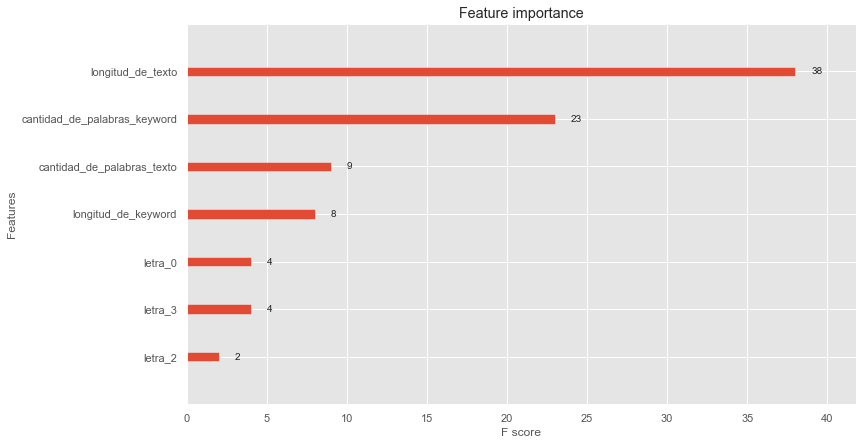

In [ ]:
plt.rcParams['figure.figsize'] = [12, 7]
xgb.plot_importance(xg_reg)

# Random Forest

In [20]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import validation_curve

In [24]:
rf = RandomForestRegressor(random_state=1, n_estimators = 20, max_features = 4, min_samples_split=10)
rf.fit(train_set, train_label)
print("Features sorted by their score:")
print(sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), list(train_set.columns)),
             reverse=True))

Features sorted by their score:
[(0.0299, 'longitud_de_keyword'), (0.0255, 'longitud_de_texto'), (0.0173, 'cantidad_de_palabras_texto'), (0.0067, 'cantidad_de_hashtag_en_texto'), (0.0056, 'keyword_palabra_3'), (0.005, 'keyword_palabra_7'), (0.0047, 'keyword_palabra_5'), (0.0047, 'keyword_palabra_2'), (0.0046, 'keyword_palabra_0'), (0.0041, 'keyword_palabra_6'), (0.0034, 'keyword_palabra_4'), (0.0032, 'train'), (0.0032, 'latest:'), (0.0032, 'debris'), (0.0031, 'suicide'), (0.0031, 'mh370:'), (0.0029, 'like'), (0.0027, 'bombing'), (0.0026, 'get'), (0.0026, 'fire'), (0.0026, 'fatal'), (0.0025, 'letra_3'), (0.0025, 'letra_2'), (0.0025, "i'm"), (0.0024, 'storm'), (0.0024, 'keyword_palabra_1'), (0.0023, 'severe'), (0.0022, 'sue'), (0.0022, 'fires'), (0.0021, 'news'), (0.0021, 'letra_0'), (0.002, 'two'), (0.002, 'letra_1'), (0.002, 'killed'), (0.0019, 'watch'), (0.0019, 'pm:'), (0.0019, 'nuclear'), (0.0017, 'via'), (0.0017, 'oil'), (0.0017, 'new'), (0.0017, 'drought'), (0.0017, 'crash'), (0.0

In [48]:
train_set_best_features = train_set[['longitud_de_keyword', 'longitud_de_texto', 'cantidad_de_palabras_texto', 'cantidad_de_hashtag_en_texto']]
train_set_best_features.head()

,longitud_de_keyword,longitud_de_texto,cantidad_de_palabras_texto,cantidad_de_hashtag_en_texto
id,,,,
1,0,69,7,1
4,0,38,7,0
5,0,133,11,0
6,0,65,7,1
7,0,88,9,2


In [49]:
train_scoreNum, test_scoreNum = validation_curve(
                                RandomForestClassifier(),
                                X = train_set_best_features, y = train_label, 
                                param_name = 'n_estimators', 
                                param_range=np.arange(1, 50),
                                cv=3, 
                                scoring="accuracy", 
                                n_jobs=-1)

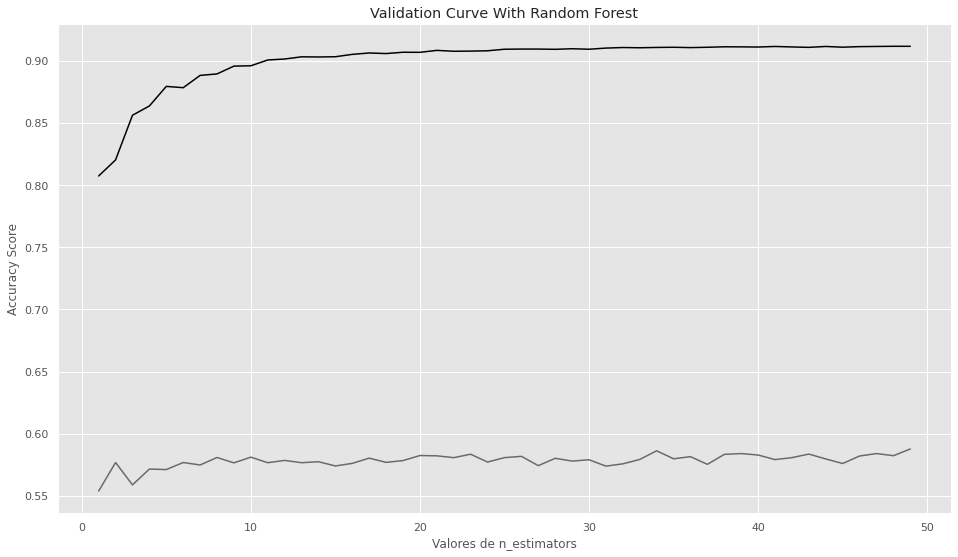

In [71]:
train_mean = np.mean(train_scoreNum, axis=1)
test_mean = np.mean(test_scoreNum, axis=1)
plt.plot(np.arange(1, 50), train_mean, label="Training score", color="black")
plt.plot(np.arange(1, 50), test_mean, label="Testing score", color="dimgrey")
plt.title("Validation Curve With Random Forest")
plt.xlabel("Valores de n_estimators")
plt.ylabel("Accuracy Score")
plt.show()

In [51]:
train_scoreNum_maxdepth, test_scoreNum_maxdepth = validation_curve(
                                RandomForestClassifier(),
                                X = train_set_best_features, y = train_label, 
                                param_name = 'max_depth', 
                                param_range=np.arange(1, 50),
                                cv=3, 
                                scoring="accuracy", 
                                n_jobs=-1)

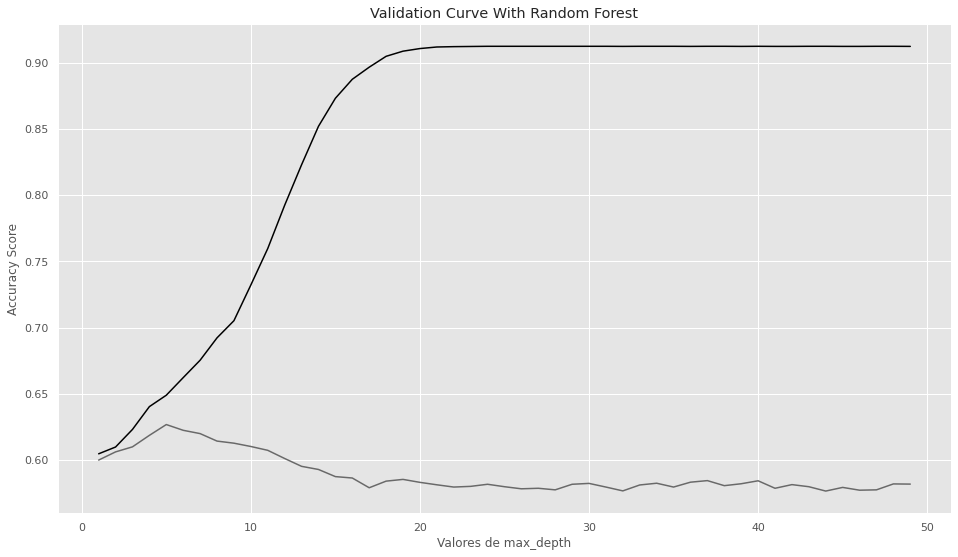

In [72]:
train_mean = np.mean(train_scoreNum_maxdepth, axis=1)
test_mean = np.mean(test_scoreNum_maxdepth, axis=1)
plt.plot(np.arange(1, 50), train_mean, label="Training score", color="black")
plt.plot(np.arange(1, 50), test_mean, label="Testing score", color="dimgrey")
plt.title("Validation Curve With Random Forest")
plt.xlabel("Valores de max_depth")
plt.ylabel("Accuracy Score")
plt.show()

In [54]:
train_scoreNum_min_samples_split, test_scoreNum_min_samples_split = validation_curve(
                                RandomForestClassifier(),
                                X = train_set_best_features, y = train_label, 
                                param_name = 'min_samples_split', 
                                param_range=np.arange(1, 50),
                                cv=3, 
                                scoring="accuracy", 
                                n_jobs=-1)

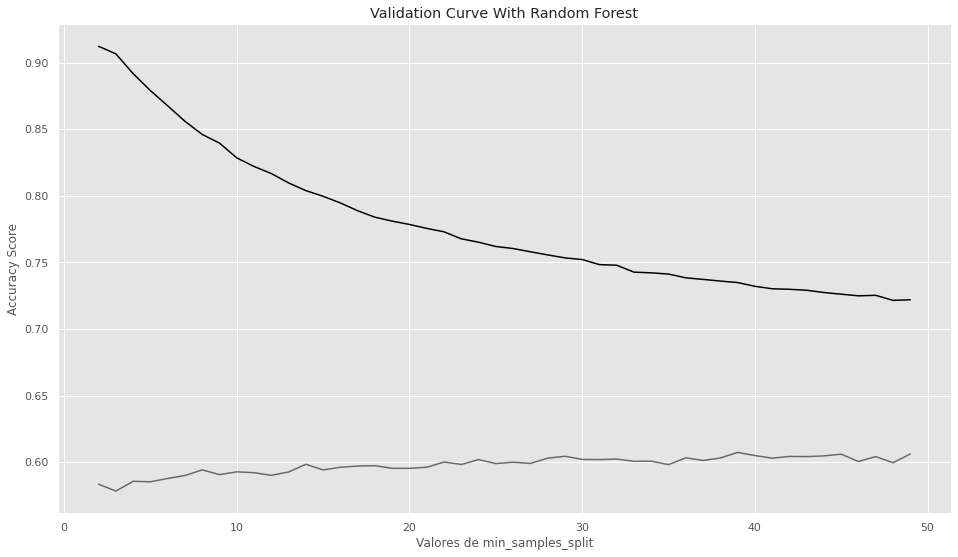

In [73]:
train_mean = np.mean(train_scoreNum_min_samples_split, axis=1)
test_mean = np.mean(test_scoreNum_min_samples_split, axis=1)
plt.plot(np.arange(1, 50), train_mean, label="Training score", color="black")
plt.plot(np.arange(1, 50), test_mean, label="Testing score", color="dimgrey")
plt.title("Validation Curve With Random Forest")
plt.xlabel("Valores de min_samples_split")
plt.ylabel("Accuracy Score")
plt.show()

In [74]:
train_scoreNum_min_samples_leaf, test_scoreNum_min_samples_leaf = validation_curve(
                                RandomForestClassifier(),
                                X = train_set_best_features, y = train_label, 
                                param_name = 'min_samples_leaf', 
                                param_range=np.arange(1, 50),
                                cv=3, 
                                scoring="accuracy", 
                                n_jobs=-1)

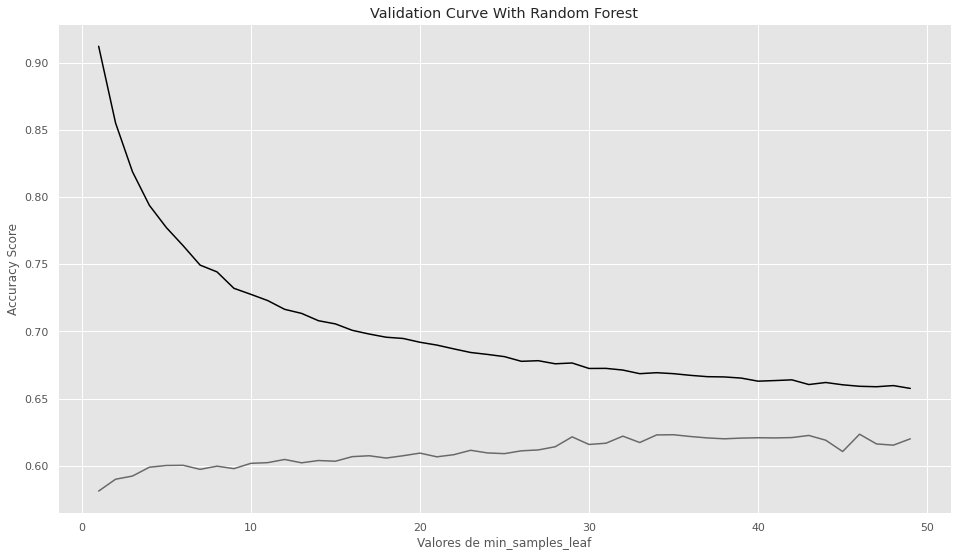

In [75]:
train_mean = np.mean(train_scoreNum_min_samples_leaf, axis=1)
test_mean = np.mean(test_scoreNum_min_samples_leaf, axis=1)
plt.plot(np.arange(1, 50), train_mean, label="Training score", color="black")
plt.plot(np.arange(1, 50), test_mean, label="Testing score", color="dimgrey")
plt.title("Validation Curve With Random Forest")
plt.xlabel("Valores de min_samples_leaf")
plt.ylabel("Accuracy Score")
plt.show()

In [87]:
rf = RandomForestRegressor(random_state=1, n_estimators = 34, max_depth = 5, min_samples_split=14, min_samples_leaf = 5)
rf.fit(train_set, train_label)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=5, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=5,
                      min_samples_split=14, min_weight_fraction_leaf=0.0,
                      n_estimators=34, n_jobs=None, oob_score=False,
                      random_state=1, verbose=0, warm_start=False)

In [88]:
predicts = rf.predict(test_set).round()
result['target'] = predicts
print(F1(result))

ValueError: ignored

In [90]:
rf = RandomForestRegressor(random_state=1, n_estimators = 20, max_features = 4, min_samples_split=10)
rf.fit(train_set, train_label)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=4, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=10, min_weight_fraction_leaf=0.0,
                      n_estimators=20, n_jobs=None, oob_score=False,
                      random_state=1, verbose=0, warm_start=False)

In [91]:
predicts = rf.predict(test_set).round()
result['target'] = predicts
print(F1(result))

ValueError: ignored

In [ ]:
plt.bar(train_set.columns, rf.feature_importances_)
plt.xlabel('Features de train')
plt.ylabel('Importancia')
plt.title('Importancia vs Features con Random Forest')
plt.show()

KeyboardInterrupt: ignored

## Redes Neuronales

In [ ]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

def build_model():
  model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=[len(train_set.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

model = build_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 128)               1136256   
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 1,144,577
Trainable params: 1,144,577
Non-trainable params: 0
_________________________________________________________________


In [ ]:
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 1000

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

history = model.fit(train_set, train_label, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])


........................

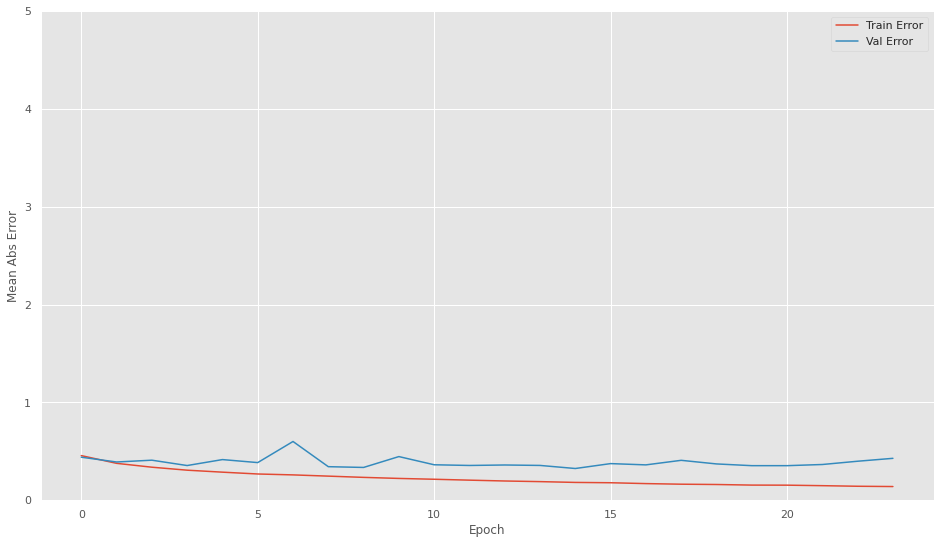

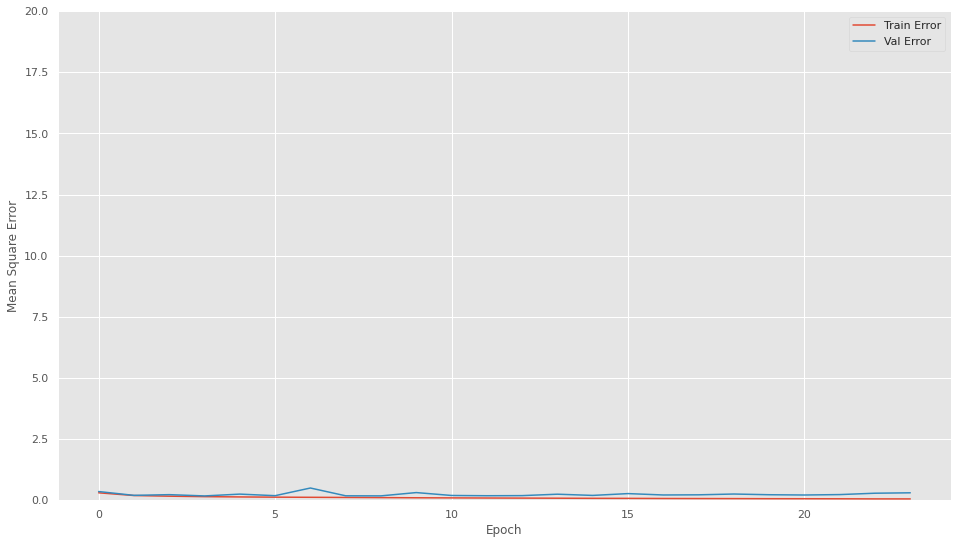

In [ ]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()


plot_history(history)

In [ ]:
preds = model.predict(np.asarray(test_set)).round()
result['target'] = preds
print(F1(result))


1199.0 935.0 204.0
0.6779756856092735


## TF-IDF

In [ ]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(solver='sag', C=10)
classifier.fit(train_set, train_label)

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='sag', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
preds = classifier.predict(test_set)
result['target'] = preds
print(F1(result))

768.0 281.0 634.0
0.6266829865361077


## ENTREGA

In [ ]:
resultados_de_prediccion.columns = ['id','target']
resultados_de_prediccion.head()

In [ ]:
#cuando todo termina el archivo de entrega
resultados_de_prediccion.to_csv('submit.csv', index=False)